<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 5: PyTorch Lightning и подбор гиперпараметров
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

План:
* Обучение моделей при помощи PyTorch Lightning
* Конфигурирование систем
* Подбор гиперпараметров при помощи Optuna

Для выполнения работы нужны следующие пакеты (Python 3):
* opencv-python
* torch
* torchvision
* pytorch_lightning
* optuna

Установить их можно командой:
```bash
pip3 install --user torch torchvision optuna opencv-python pytorch_lightning
```

In [1]:
import numpy as np
import optuna
import pytorch_lightning as pl
import torch
import torchvision

from matplotlib import pyplot as plt

from seminar import make_grid

USE_CUDA = torch.cuda.is_available()
CUDA_DEVICES = [0]

BATCHSIZE = 64
EPOCHS = 5

DATA_ROOT = "data"
TRAIN_ROOT = "train"

print("PyTorch version: {}".format(torch.__version__))
print("Use CUDA: {}".format(USE_CUDA))

PyTorch version: 1.7.1
Use CUDA: True


### Типичный ML pipeline.

<img src="resources/bicycle.jpg" width="35%" height="35%" align="left">
<div style="clear:both;"></div>

Большое количество кода повторяется от проекта к проекту:
* Тренировочный цикл
* Управление чекпоинтами
* Работа с GPU и распределённая тренировка

Типичные пайплайны уже реализованы в высокоуровневых библиотеках:
* TensorFlow Estimator
* PyTorch Ignite
* PyTorch Lightning

См. сравнение Ignite vs Lightning:

https://towardsdatascience.com/pytorch-lightning-vs-pytorch-ignite-vs-fast-ai-61dc7480ad8a

### Pytorch Lightning

<img src="resources/lightning.png" align="left">
<div style="clear:both;"></div>

# Тренировка с Pytorch Lightning

Создадим три базовых класса: LightningDataModule, LightningModule, Trainer.

### LightningDataModule

* Хранит информацию о Train/Dev/Test корпусах
* Создаёт DataLoader-ы

Если нужно несколько корупсов:

https://pytorch-lightning.readthedocs.io/en/stable/multiple_loaders.html

Files already downloaded and verified
Files already downloaded and verified
train size: 50000


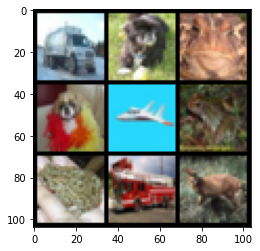

dev size: 5000


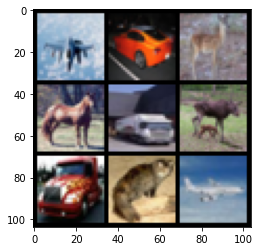

test size: 5000


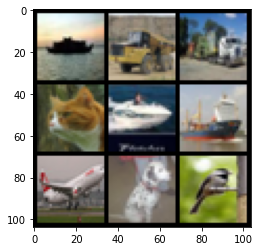

In [3]:
class DataModule(pl.LightningDataModule):
    """Handles Train/Dev/Test sets and data loading."""
    
    def __init__(self, data_root, batch_size):
        super().__init__()
        self._data_root = data_root
        
        self._labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        
        self._loader_params = {
            "pin_memory": True if USE_CUDA else False,
            "batch_size": batch_size,
            "num_workers": 1  # Prepare data in parallel.
        }
        
    @property
    def num_classes(self):
        return len(self._labels)
    
    @property
    def labels(self):
        return self._labels
    
    def setup(self, stage=None):
        transform = torchvision.transforms.ToTensor()
        kwargs = {
            "download": True,
            "transform": transform
        }
        trainset = torchvision.datasets.CIFAR10(self._data_root, train=True, download=True, transform=transform)
        devtestset = torchvision.datasets.CIFAR10(self._data_root, train=False, download=True, transform=transform)
        
        length = len(devtestset) // 2
        generator = torch.Generator().manual_seed(42)
        devset, testset = torch.utils.data.random_split(devtestset,
                                                        [length, length],
                                                        generator=generator)
        self._datasets = {
            "train": trainset,
            "dev": devset,
            "test": testset
        }

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["train"], **self._loader_params)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["dev"], **self._loader_params)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["test"], **self._loader_params)

    def show(self, tag="train"):
        dataset = self._datasets[tag]
        print("{} size: {}".format(tag, len(dataset)))
        samples = [dataset[i][0] for i in np.random.choice(range(len(dataset)), 9)]
        plt.imshow(torchvision.utils.make_grid(samples, nrow=3).permute(1, 2, 0))
        plt.show()

        
data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
data.setup()
for tag in ["train", "dev", "test"]:
    data.show(tag)

### LightningModule

Объединяет:
* Модель
* Loss
* Оптимизатор

In [4]:
class Module(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self._model = torchvision.models.resnet18(num_classes=num_classes, pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()
        
    @property
    def model(self):
        return self._model
        
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        self.log("TrainLoss", loss)
        return loss

### Trainer

Реализует пайплайн обучения. Наследовать не нужно.

In [5]:
data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
module = Module(num_classes=data.num_classes)

trainer = pl.Trainer(
    default_root_dir=TRAIN_ROOT,
    gpus=0 if not USE_CUDA else CUDA_DEVICES,
    max_epochs=2
)
trainer.fit(module, data)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/imd/miniconda3/envs/made_dl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
/home/imd/miniconda3/envs/made_dl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

1

Запустить tensorboard server:
```bash
tensorboard --logdir ./train
```

По умолчанию сервер запустится на 6006 порту.

<img src="resources/board-1-simple.png" align="left">
<div style="clear:both;"></div>

### Вопросы

# Extra logs

* Добавим логгирование Dev loss.
* Tensorboard обновляется каждые 2 минуты. Уменьшим до 10 секунд.
* Логируется каждый 50-й батч. Увеличим до 100.
* Добавим в Tensorboard изображения с предсказаниями.

In [9]:
class Module(pl.LightningModule):
    def __init__(self, num_classes, labels):
        super().__init__()
        self._labels = labels
        self._model = torchvision.models.resnet18(num_classes=num_classes, pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()
        
    @property
    def model(self):
        return self._model
        
    def configure_optimizers(self):
        return torch.optim.Adam(self._model.parameters(), lr=1e-3)
    
    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        loss = self._compute_loss(batch)
        if self.global_step % 100 == 0:  # NEW.
            # Train curve will be plotted on the common Loss plot.
            self.logger.experiment.add_scalars("Loss", {"train": loss},
                                               global_step=self.global_step)
        if self.global_step % 500 == 0:  # NEW.
            # Show predicted images.
            self._plot(batch)
        return loss
    
    # NEW CODE BELOW. 
    def validation_step(self, batch, batch_idx):
        """Process single batch during validation."""
        return self._compute_loss(batch)
    
    def validation_epoch_end(self, losses):
        """Accumulate and log validation losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"dev": loss},
                                           global_step=self.global_step)
    
    def test_step(self, batch, batch_idx):
        """Process single batch during testing."""
        return self._compute_loss(batch)
    
    def test_epoch_end(self, losses):
        """Accumulate and log test losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"test": loss},
                                           global_step=self.global_step)
    
    def _compute_loss(self, batch):
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        return loss
    
    def _plot(self, batch, size=9):
        predictions = self._model(batch[0]).argmax(1)
        grid = make_grid(batch[0], predictions, self._labels)
        # Add image to TensorBoard.
        self.logger.experiment.add_image("Predictions", grid,
                                         global_step=self.global_step)
        
data = DataModule(DATA_ROOT, batch_size=BATCHSIZE)
module = Module(num_classes=data.num_classes, labels=data.labels)

# Train dir will have the following structure:
# root
#   - experiment
#      - version
#         - checkpoints
#         - <logs>

logger = pl.loggers.TensorBoardLogger(
    save_dir=TRAIN_ROOT,  # Root for all experiments.
    name="extra_logs",  # Experiment name, same as subdirectory name.
    # version=0,  #  You can choose specific experiment version.
    flush_secs=10  # Update TensorBoard every 10 seconds.
)

trainer = pl.Trainer(
    logger=logger,
    gpus=0 if not USE_CUDA else CUDA_DEVICES,
    max_epochs=2
)

trainer.fit(module, data)
trainer.test()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
/home/imd/miniconda3/envs/made_dl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/imd/miniconda3/envs/made_dl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

<img src="resources/board-2-plot.png" align="left">
<div style="clear:both;"></div>

### More options
* Train using 2 GPUs
* Train in FP16

In [10]:
logger = pl.loggers.TensorBoardLogger(
    save_dir=TRAIN_ROOT,  # Root for all experiments.
    name="fp16",  # Experiment name, same as subdirectory name.
    # version=0,  #  You can choose specific experiment version.
    flush_secs=10  # Update TensorBoard every 10 seconds.
)

trainer = pl.Trainer(
    logger=logger,
    gpus=[0],
    distributed_backend="dp",  # "ddp" better, but doesn't work with Jupyter.
    precision=16,
    max_epochs=EPOCHS
)

trainer.fit(module, data)
trainer.test()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11.2 M
1 | _loss  | CrossEntropyLoss | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
/home/imd/miniconda3/envs/made_dl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/imd/miniconda3/envs/made_dl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/imd/miniconda3/envs/made_dl/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

<img src="resources/gpu-usage.png" align="left">
<div style="clear:both;"></div>

<img src="resources/board-3-fp16.png" align="left">
<div style="clear:both;"></div>

Вопросы

# Конфигурация систем

### Плоский конфиг

In [15]:
class Head(torch.nn.Sequential):
    def __init__(self, input_size, output_size, bottleneck_size):
        super().__init__(
            torch.nn.Linear(input_size, bottleneck_size),
            torch.nn.ReLU(),
            torch.nn.Linear(bottleneck_size, output_size)
        )

class Model(torch.nn.Module):
    def __init__(self, input_size, bottleneck_size,
                 head1_bottleneck_size, head1_output_size,
                 head2_bottleneck_size, head2_output_size):
        super().__init__()
        self._stem = torch.nn.Linear(input_size, bottleneck_size)
        self._head1 = Head(bottleneck_size, head1_output_size, head1_bottleneck_size)
        self._head2 = Head(bottleneck_size, head2_output_size, head2_bottleneck_size)

    def forward(self, batch):
        embeddings = self._stem(batch)
        output1 = self._head1(embeddings)
        output2 = self._head2(embeddings)
        return output1, output2

config = {
    "bottleneck_size": 512,
    "head1_output_size": 128,
    "head1_bottleneck_size": 256,
    "head2_output_size": 64,
    "head2_bottleneck_size": 256
}

Model(
    input_size=128,
    bottleneck_size=config["bottleneck_size"],
    head1_output_size=config["head1_output_size"],
    head1_bottleneck_size=config["head1_bottleneck_size"],
    head2_output_size=config["head2_output_size"],
    head2_bottleneck_size=config["head2_bottleneck_size"]
)

Model(
  (_stem): Linear(in_features=128, out_features=512, bias=True)
  (_head1): Head(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (_head2): Head(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
)


Плюсы:

<span style="color:green">
    
* самый популярный вариант
* самый простой и понятный
</span>

Минусы:

<span style="color:red">
    
* высокоуровневые классы разрастаются при появлении новых опций
* конфиг должен хранить все параметры и устаревает при появлении новых
* высокоуровневые классы сильно связаны с реализации вложенных
    
</span>

In [10]:
help(torchvision.models.detection.FasterRCNN.__init__)

Help on function __init__ in module torchvision.models.detection.faster_rcnn:

__init__(self, backbone, num_classes=None, min_size=800, max_size=1333, image_mean=None, image_std=None, rpn_anchor_generator=None, rpn_head=None, rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000, rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000, rpn_nms_thresh=0.7, rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3, rpn_batch_size_per_image=256, rpn_positive_fraction=0.5, box_roi_pool=None, box_head=None, box_predictor=None, box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100, box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5, box_batch_size_per_image=512, box_positive_fraction=0.25, bbox_reg_weights=None)
    Initializes internal Module state, shared by both nn.Module and ScriptModule.



### Иерархический конфиг

In [16]:
class Head(torch.nn.Sequential):
    def __init__(self, input_size, config):
        super().__init__(
            torch.nn.Linear(input_size, config["bottleneck_size"]),
            torch.nn.ReLU(),
            torch.nn.Linear(config["bottleneck_size"], config["output_size"])
        )
        self._config = config

    @property
    def output_size(self):
        return self._config["output_size"]


class Model(torch.nn.Module):
    def __init__(self, input_size, config):
        super().__init__()
        self._stem = torch.nn.Linear(input_size, config["bottleneck_size"])
        self._head1 = Head(config["bottleneck_size"], config=config["head1_params"])
        self._head2 = Head(config["bottleneck_size"], config=config["head2_params"])

    @property
    def output_size(self):
        return (self._head1.output_size, self._head2.output_size)

    def forward(self, batch):
        embeddings = self._stem(batch)
        output1 = self._head1(embeddings)
        output2 = self._head2(embeddings)
        return output1, output2


config = {
    "bottleneck_size": 512,
    "head1_params": {
        "bottleneck_size": 128,
        "output_size": 128
    },
    "head2_params": {
        "bottleneck_size": 128,
        "output_size": 64
    }
}

Model(128, config=config)

Model(
  (_stem): Linear(in_features=128, out_features=512, bias=True)
  (_head1): Head(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (_head2): Head(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
)

### Иерархический конфиг с параметрами по умолчанию

In [32]:
from collections import OrderedDict
from config import prepare_config, ConfigError

class Configurable:
    @staticmethod
    def get_default_config():
        return {
            "a": 5,
            "b": 8
        }
    
obj = Configurable()

In [28]:
prepare_config(obj)

OrderedDict([('a', 5), ('b', 8)])

In [29]:
prepare_config(obj, config={"a": 10})

OrderedDict([('a', 10), ('b', 8)])

In [30]:
try:
    prepare_config(obj, config={"c": 5})
except ConfigError as e:
    print("EXCEPTION:", e)

EXCEPTION: Unknown parameter c


Вопросы

Применим ирархические конфиги к нашей модели
* Добавим значения по умолчанию
* Добавим выбор функции активации во вложенном классе

In [33]:
class Head(torch.nn.Sequential):
    ACTIVATIONS = {
        "relu": torch.nn.ReLU,
        "tanh": torch.nn.Tanh
    }

    @staticmethod
    def get_default_config(bottleneck_size=256, output_size=128, activation="relu"):
        """Get head config.

        Args:
            bottleneck_size: ...
            output_size: ...
            activation: ...
        """
        return OrderedDict([
            ("bottleneck_size", bottleneck_size),
            ("output_size", output_size),
            ("activation", activation)
        ])

    def __init__(self, input_size, config=None):
        config = prepare_config(self, config)
        super().__init__(
            torch.nn.Linear(input_size, config["bottleneck_size"]),
            self.ACTIVATIONS[config["activation"]](),
            torch.nn.Linear(config["bottleneck_size"], config["output_size"])
        )
        self._config = config

    @property
    def output_size(self):
        return self._config["output_size"]


class Model(torch.nn.Module):
    @staticmethod
    def get_default_config(bottleneck_size=512, head1_params=None, head2_params=None):
        """Get model config.

        Args:
            head1_params: ...
            head2_params: ...
        """
        return OrderedDict([
            ("bottleneck_size", bottleneck_size),
            ("head1_params", head1_params),
            ("head2_params", head2_params)
        ])

    def __init__(self, input_size, config=None):
        super().__init__()
        config = prepare_config(self, config)
        self._stem = torch.nn.Linear(input_size, config["bottleneck_size"])
        self._head1 = Head(config["bottleneck_size"], config=config["head1_params"])
        self._head2 = Head(config["bottleneck_size"], config=config["head2_params"])

    @property
    def output_size(self):
        return (self._head1.output_size, self._head2.output_size)

    def forward(self, batch):
        embeddings = self._stem(batch)
        output1 = self._head1(embeddings)
        output2 = self._head2(embeddings)
        return output1, output2


config = {
    "head1_params": {
        "activation": "tanh"
    },
    "head2_params": {
        "bottleneck_size": 64
    }
}

Model(128, config=config)

Model(
  (_stem): Linear(in_features=128, out_features=512, bias=True)
  (_head1): Head(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (_head2): Head(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
  )
)

Фрагмент реального конфига:

In [41]:
{
    "feature_dim": 13,
    "backbone_params": {
        "cnn_params": {
            "channels": [32, 64, 128, 256],
            "kernel": [1, 3],
            "stride": [1, 1],
            "activation": "lrelu_inplace",
            "pooling": None,
            "normalization": "instance"
        },
        "rnn_params": {
            "units": [256],
            "bidirectional": True,
            "normalization": "layer"
        },
        "fc_params": {
            "units": [256, 256, 63],
            "normalization": "layer",
            "activation": "relu_inplace"
        },
        "no_head_labels": ["base_label"],
        "labels": ["base_label", "label1", "label2"],
        "cnn_features_as_channels": True
    },
    "output_label": "label1",
    "model": "crnn_gmm",
    "head_params": {
        "n_components": 3,
        "scale": 0.01,
        "feature_dim": 10
    },
    "selector": "max_weight",
    "selector_params": {
        "ignore_components": [2]
    }
}
None


Плюсы:

<span style="color:green">
    
* параметризация изолирована в каждом классе
* при добавлении новых параметров старые конфиги не устаревают, если значения по умолчанию воспроизводят старую логику
* автоматически проверяется правильность конфига (отсутствие лишних параметров)
</span>

Минусы:

<span style="color:red">
    
* бывает сложно найти соответствующий параметру класс (в плоском конфиге можно дать развернутое имя: generator_lr вместо lr)
    
</span>

# Подбор гиперпараметров при помощи Optuna

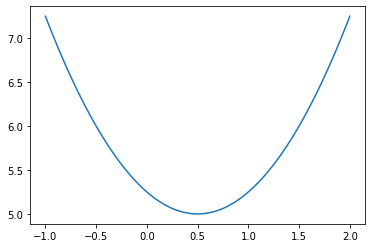

In [50]:
loss = lambda x, y: (x - 0.5) ** 2 + y * 0.01 + 5

xs = np.linspace(-1, 2, 100)
plt.plot(xs, loss(xs, xs * 0))
plt.show()

In [55]:
def experiment(trial):
    x = trial.suggest_float("x", -10, 10)
    y = trial.suggest_float("y", -10, 10)
    return loss(x, y)

optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()
study.optimize(experiment, n_trials=50, n_jobs=5)

optuna.logging.set_verbosity(optuna.logging.INFO)

print("Value:", study.best_value)
print("Parameters:", study.best_params)
print("Importance:", optuna.importance.get_param_importances(study))

Value: 4.9604086320759
Parameters: {'x': 0.5018090900057561, 'y': -3.95946407307491}
Importance: OrderedDict([('x', 0.9966649307555144), ('y', 0.0033350692444855216)])


# Конфиги и гиперпараметры

Метод prepare_config умеет парсить гиперпараметры. Дял этого нужен контекст suggest_config.

In [2]:
from collections import OrderedDict
from config import prepare_config, suggest_config, ConfigError

class Configurable:
    @staticmethod
    def get_default_config():
        return {
            "num_layers": 16
        }
    
def experiment(trial):
    config = {
        "_hyper": {
            "num_layers": {
                "type": "int",
                "low": 16,
                "high": 32,
                "step": 8
            }
        },
        "num_layers": 5
    }
    with suggest_config(trial):
        print(prepare_config(Configurable(), config))
    return np.random.random()
        
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study()
study.optimize(experiment, n_trials=5)

optuna.logging.set_verbosity(optuna.logging.INFO)

OrderedDict([('num_layers', 16)])
OrderedDict([('num_layers', 24)])
OrderedDict([('num_layers', 32)])
OrderedDict([('num_layers', 16)])
OrderedDict([('num_layers', 16)])


### Конфигурируемый Optimizer

In [2]:
from collections import OrderedDict
from config import prepare_config, suggest_config, ConfigError

class AdamOptimizer(torch.optim.Adam):
    @staticmethod
    def get_default_config(lr=1e-3, beta1=0.9, beta2=0.999, weight_decay=0, amsgrad=False):
        return OrderedDict([
            ("lr", lr),
            ("beta1", beta1),
            ("beta2", beta2),
            ("weight_decay", weight_decay),
            ("amsgrad", amsgrad)
        ])

    def __init__(self, params, config=None):
        config = prepare_config(self, config)
        super().__init__(params,
                         lr=config["lr"],
                         betas=(config["beta1"], config["beta2"]),
                         weight_decay=config["weight_decay"],
                         amsgrad=config["amsgrad"])


class SGDOptimizer(torch.optim.SGD):
    @staticmethod
    def get_default_config(lr=1e-3, momentum=0, weight_decay=0, nesterov=False):
        return OrderedDict([
            ("lr", lr),
            ("momentum", momentum),
            ("weight_decay", weight_decay),
            ("nesterov", nesterov)
        ])

    def __init__(self, params, config=None):
        config = prepare_config(self, config)
        super().__init__(params,
                         lr=config["lr"],
                         momentum=config["momentum"],
                         weight_decay=config["weight_decay"],
                         nesterov=config["nesterov"])


class Optimizer(torch.optim.Optimizer):
    OPTIMIZERS = {
        "adam": AdamOptimizer,
        "sgd": SGDOptimizer
    }

    @staticmethod
    def get_default_config(optimizer="adam", optimizer_params=None):
        return OrderedDict([
            ("optimizer", optimizer),
            ("optimizer_params", optimizer_params)
        ])

    def __init__(self, params, config=None):
        # No super().__init__. Inheritance is only for PyTorch Lightning checks.
        self._config = prepare_config(self, config)
        self._optimizer = self.OPTIMIZERS[self._config["optimizer"]](params, self._config["optimizer_params"])

    def step(self, closure=None):
        kwargs = {}
        if closure is not None:
            kwargs["closure"] = closure
        self._optimizer.step(**kwargs)

    def zero_grad(self):
        self._optimizer.zero_grad()

    def state_dict(self):
        return self._optimizer.state_dict()

    def load_state_dict(self, state_dict):
        self._optimizer.load_state_dict(state_dict)

    @property
    def param_groups(self):
        return self._optimizer.param_groups

    @property
    def state(self):
        return self._optimizer.state

### Конфигурируемый DataModule

In [3]:
class DataModule(pl.LightningDataModule):
    """Handles Train/Dev/Test sets and data loading."""
    
    @staticmethod
    def get_default_config(batch_size=64):
        return OrderedDict([
            ("batch_size", batch_size)
        ])
    
    def __init__(self, data_root, config=None):
        super().__init__()
        config = prepare_config(self, config)
        self._data_root = data_root
        
        self._labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
        
        self._loader_params = {
            "pin_memory": True if USE_CUDA else False,
            "batch_size": config["batch_size"],
            "num_workers": 1  # Prepare data in parallel.
        }
        
    @property
    def num_classes(self):
        return len(self._labels)
    
    @property
    def labels(self):
        return self._labels
    
    def setup(self, stage=None):
        transform = torchvision.transforms.ToTensor()
        kwargs = {
            "download": True,
            "transform": transform
        }
        trainset = torchvision.datasets.CIFAR10(self._data_root, train=True, download=True, transform=transform)
        devtestset = torchvision.datasets.CIFAR10(self._data_root, train=False, download=True, transform=transform)
        
        length = len(devtestset) // 2
        generator = torch.Generator().manual_seed(42)
        devset, testset = torch.utils.data.random_split(devtestset,
                                                        [length, length],
                                                        generator=generator)
        self._datasets = {
            "train": trainset,
            "dev": devset,
            "test": testset
        }

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["train"], **self._loader_params)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["dev"], **self._loader_params)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self._datasets["test"], **self._loader_params)

    def show(self, tag="train"):
        dataset = self._datasets[tag]
        print("{} size: {}".format(tag, len(dataset)))
        samples = [dataset[i][0] for i in np.random.choice(range(len(dataset)), 9)]
        plt.imshow(torchvision.utils.make_grid(samples, nrow=3).permute(1, 2, 0))
        plt.show()

### Конфигурируемый Module

In [4]:
class Module(pl.LightningModule):
    MODELS = {
        "resnet18": torchvision.models.resnet18,
        "resnet34": torchvision.models.resnet34
    }
    
    @staticmethod
    def get_default_config(model="resnet18", optimizer_params=None):
        return OrderedDict([
            ("model", model),
            ("optimizer_params", optimizer_params)
        ])
    
    def __init__(self, num_classes, labels, config=None):
        super().__init__()
        self._config = prepare_config(self, config)
        self._labels = labels
        self._model = self.MODELS[self._config["model"]](num_classes=num_classes, pretrained=False)
        self._loss = torch.nn.CrossEntropyLoss()
        
    @property
    def model(self):
        return self._model
        
    def configure_optimizers(self):
        return Optimizer(self._model.parameters(), config=self._config["optimizer_params"])
    
    def training_step(self, batch, batch_idx):
        """Process single batch during training."""
        loss = self._compute_loss(batch)
        if self.global_step % 100 == 0:
            # Train curve will be plotted on the common Loss plot.
            self.logger.experiment.add_scalars("Loss", {"train": loss},
                                               global_step=self.global_step)
        if self.global_step % 500 == 0:
            self._plot(batch)
        return loss
    
    def validation_step(self, batch, batch_idx):
        """Process single batch during validation."""
        return self._compute_loss(batch)
    
    def validation_epoch_end(self, losses):
        """Accumulate and log validation losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"dev": loss},
                                           global_step=self.global_step)
        # Return validation loss for early stopping.
        return {"val_loss": loss}
    
    def test_step(self, batch, batch_idx):
        """Process single batch during testing."""
        return self._compute_loss(batch)
    
    def test_epoch_end(self, losses):
        """Accumulate and log test losses."""
        loss = torch.stack(losses).mean()
        self.logger.experiment.add_scalars("Loss", {"test": loss},
                                           global_step=self.global_step)
    
    def _compute_loss(self, batch):
        images, labels = batch
        predictions = self._model(images)
        loss = self._loss(predictions, labels).mean()
        return loss
    
    def _plot(self, batch, size=9):
        predictions = self._model(batch[0]).argmax(1)
        grid = make_grid(batch[0], predictions, self._labels)
        # Add image to TensorBoard.
        self.logger.experiment.add_image("Predictions", grid,
                                         global_step=self.global_step)

### Объединим в одну систему

In [7]:
class Experiment:
    @staticmethod
    def get_default_config(data_params=None, module_params=None, use_fp16=False):
        return OrderedDict([
            ("seed", 42),
            ("data_params", data_params),
            ("module_params", module_params),
            ("use_fp16", use_fp16)
        ])
    
    def __init__(self, train_root, config=None):
        self._train_root = train_root
        self._config = config
        
    def __call__(self, trial):
        with suggest_config(trial):
            config = prepare_config(self, self._config)
            
            torch.manual_seed(config["seed"])
            np.random.seed(config["seed"])
            
            data = DataModule(DATA_ROOT, config=config["data_params"])
            module = Module(data.num_classes, data.labels,
                            config=config["module_params"])

            logger = pl.loggers.TensorBoardLogger(
                save_dir=self._train_root,  # Root for all experiments.
                name="hyper",  # Experiment name, same as subdirectory name.
                flush_secs=10  # Update TensorBoard every 10 seconds.
            )

            trainer = pl.Trainer(
                logger=logger,
                gpus=1 if USE_CUDA else 0,
                distributed_backend="dp",  # "ddp" better, but doesn't work with Jupyter.
                precision=16 if config["use_fp16"] else 32,
                max_epochs=EPOCHS,

                # Optuna callback for early stopping.
                callbacks=[optuna.integration.PyTorchLightningPruningCallback(trial, monitor="val_loss")]
            )

            trainer.fit(module, data)
        return trainer.callback_metrics["val_loss"].item()
        
import os
os.makedirs(TRAIN_ROOT, exist_ok=True)
study = optuna.create_study("sqlite:///{}/study.db".format(TRAIN_ROOT))

config = {
    "_hyper": {
        "seed": {"type": "int", "low": 0, "high": 10}
    },
    "data_params": {
        "_hyper": {
            "batch_size": {"type": "int", "low": 64, "high": 512, "step": 64}
        }
    },
    "module_params": {
        "_hyper": {
            "model": {"choices": ["resnet18", "resnet34"]}
        },
        "optimizer_params": {
            "_hyper": {
                "optimizer": {
                    "choices": ["adam", "sgd"]
                }
            },
            "optimizer_params": {
                "_hyper": {
                    "lr": {"type": "float", "low": 1e-5, "high": 1e-2},
                    "amsgrad": {"choices": [True, False]},
                    "nesterov": {"choices": [True, False]},
                    "weight_decay": {"type": "float", "low": 0, "high": 1e-4},
                    "momentum": {"type": "float", "low": 0, "high": 1}
                }
            }
        }
    }
}

study.optimize(Experiment(TRAIN_ROOT, config=config), n_trials=100)
result = {
    "value": study.best_value,
    "params": study.best_params,
    "importance": optuna.importance.get_param_importances(study)
}

import json
with open(os.path.join(TRAIN_ROOT, "result.json"), "w") as fp:
    json.dump(result, fp)

print(result)

[I 2021-02-17 11:08:42,712] A new study created in RDB with name: no-name-951b3e11-eaab-498f-b63f-aacd3eab732d
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     
/home/ivan.karpukhin/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



/home/ivan.karpukhin/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The validation_epoch_end should not return anything as of 9.1.to log, use self.log(...) or self.write(...) directly in the LightningModule

/home/ivan.karpukhin/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning:

The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



[I 2021-02-17 11:09:31,828] Trial 0 finished with value: 1.569098711013794 and parameters: {'seed': 4, 'data_params.batch_size': 512, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.006788958154935185, 'module_params.optimizer_params.optimizer_params.amsgrad': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 1.3484180052174167e-05}. Best is trial 0 with value: 1.569098711013794.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:10:33,876] Trial 1 finished with value: 1.574021816253662 and parameters: {'seed': 4, 'data_params.batch_size': 448, 'module_params.model': 'resnet34', 'module_params.optimizer_params.optimizer': 'sgd', 'module_params.optimizer_params.optimizer_params.lr': 0.003379193427633696, 'module_params.optimizer_params.optimizer_params.nesterov': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 6.129728379914434e-08, 'module_params.optimizer_params.optimizer_params.momentum': 0.014844240209104465}. Best is trial 0 with value: 1.569098711013794.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:11:33,587] Trial 2 finished with value: 1.885999083518982 and parameters: {'seed': 5, 'data_params.batch_size': 192, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'sgd', 'module_params.optimizer_params.optimizer_params.lr': 0.007518957953665646, 'module_params.optimizer_params.optimizer_params.nesterov': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 3.3139012575785955e-05, 'module_params.optimizer_params.optimizer_params.momentum': 0.019391069906616654}. Best is trial 0 with value: 1.569098711013794.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:12:25,199] Trial 3 finished with value: 1.302428126335144 and parameters: {'seed': 9, 'data_params.batch_size': 384, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.008284362265198702, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 3.616664487624737e-05}. Best is trial 3 with value: 1.302428126335144.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:13:34,726] Trial 4 finished with value: 1.2246416807174683 and parameters: {'seed': 8, 'data_params.batch_size': 256, 'module_params.model': 'resnet34', 'module_params.optimizer_params.optimizer': 'sgd', 'module_params.optimizer_params.optimizer_params.lr': 0.005009187623442288, 'module_params.optimizer_params.optimizer_params.nesterov': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 8.385917643358432e-05, 'module_params.optimizer_params.optimizer_params.momentum': 0.951034214551072}. Best is trial 4 with value: 1.2246416807174683.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:14:08,316] Trial 5 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:14:28,534] Trial 6 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:14:49,765] Trial 7 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:15:04,695] Trial 8 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:15:23,850] Trial 9 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:17:04,778] Trial 10 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:17:22,544] Trial 11 pruned. Trial was pruned at epoch 0.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:17:39,068] Trial 12 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:18:11,941] Trial 13 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:18:27,058] Trial 14 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:19:33,262] Trial 15 finished with value: 1.001844882965088 and parameters: {'seed': 10, 'data_params.batch_size': 192, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.003372349533871546, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.2655162237127503e-05}. Best is trial 15 with value: 1.001844882965088.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:20:41,622] Trial 16 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:20:56,926] Trial 17 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:21:44,233] Trial 18 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:24:07,310] Trial 19 finished with value: 1.1114673614501953 and parameters: {'seed': 6, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.003942801758611941, 'module_params.optimizer_params.optimizer_params.amsgrad': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 4.903795442577645e-05}. Best is trial 15 with value: 1.001844882965088.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:26:31,010] Trial 20 finished with value: 1.1384693384170532 and parameters: {'seed': 2, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0036123518779748467, 'module_params.optimizer_params.optimizer_params.amsgrad': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 4.9096079908604065e-05}. Best is trial 15 with value: 1.001844882965088.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:27:58,529] Trial 21 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:29:25,119] Trial 22 finished with value: 0.9783057570457458 and parameters: {'seed': 3, 'data_params.batch_size': 128, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0016763384870855018, 'module_params.optimizer_params.optimizer_params.amsgrad': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.2733093402700583e-05}. Best is trial 22 with value: 0.9783057570457458.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:30:17,846] Trial 23 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:30:37,264] Trial 24 pruned. Trial was pruned at epoch 0.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:30:52,494] Trial 25 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:33:16,223] Trial 26 finished with value: 1.1669784784317017 and parameters: {'seed': 0, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0013439555812320737, 'module_params.optimizer_params.optimizer_params.amsgrad': False, 'module_params.optimizer_params.optimizer_params.weight_decay': 5.519661867013695e-05}. Best is trial 22 with value: 0.9783057570457458.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:34:10,846] Trial 27 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:34:52,216] Trial 28 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:37:19,247] Trial 29 finished with value: 0.8637028932571411 and parameters: {'seed': 3, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.004210491006189483, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.5605011637886994e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:37:56,501] Trial 30 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:40:23,919] Trial 31 finished with value: 0.93672114610672 and parameters: {'seed': 2, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.004122764982280219, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.856568375546844e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:40:56,548] Trial 32 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:41:15,907] Trial 33 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]



Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:41:31,299] Trial 34 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:43:59,607] Trial 35 finished with value: 0.9832636713981628 and parameters: {'seed': 1, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0031065283148353218, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 3.76800930391089e-05}. Best is trial 29 with value: 0.8637028932571411.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:46:27,241] Trial 36 finished with value: 0.9697499871253967 and parameters: {'seed': 1, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0017112934436815963, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 3.812350907518539e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:48:54,640] Trial 37 finished with value: 0.9671345353126526 and parameters: {'seed': 3, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0018742462604989922, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 3.158010257022442e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:51:21,091] Trial 38 finished with value: 1.0224366188049316 and parameters: {'seed': 2, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.001153765878877679, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 3.3097703745524846e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:51:51,946] Trial 39 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:52:23,453] Trial 40 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:53:51,057] Trial 41 finished with value: 1.1590710878372192 and parameters: {'seed': 3, 'data_params.batch_size': 128, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0018404711335155454, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.691484484056478e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:54:22,137] Trial 42 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:54:41,353] Trial 43 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:55:41,773] Trial 44 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]



Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:56:18,416] Trial 45 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:58:45,359] Trial 46 finished with value: 1.7387492656707764 and parameters: {'seed': 1, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0010290229001241279, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 1.413344626989155e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 11:59:04,705] Trial 47 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:00:04,642] Trial 48 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:00:17,388] Trial 49 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:00:35,194] Trial 50 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]




Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:03:01,186] Trial 51 finished with value: 1.0318686962127686 and parameters: {'seed': 1, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0031950872538324174, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 3.818991232638325e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:03:31,922] Trial 52 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:05:58,920] Trial 53 finished with value: 0.9015278816223145 and parameters: {'seed': 2, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.002982464638418616, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 4.37412942844975e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:06:29,757] Trial 54 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:06:41,225] Trial 55 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:07:00,383] Trial 56 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:09:25,275] Trial 57 finished with value: 1.0526983737945557 and parameters: {'seed': 2, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.001464907915129318, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 5.386402533296729e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:10:01,619] Trial 58 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:10:16,228] Trial 59 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:10:40,838] Trial 60 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:11:11,494] Trial 61 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:11:42,437] Trial 62 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:12:14,019] Trial 63 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:13:13,722] Trial 64 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:13:44,504] Trial 65 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:14:21,071] Trial 66 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]



Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:14:57,703] Trial 67 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:15:28,370] Trial 68 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:16:08,649] Trial 69 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:16:20,884] Trial 70 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:16:35,973] Trial 71 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:16:51,211] Trial 72 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]




Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:17:06,593] Trial 73 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:17:25,674] Trial 74 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:18:20,405] Trial 75 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:19:20,501] Trial 76 pruned. Trial was pruned at epoch 1.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:19:32,980] Trial 77 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:20:27,105] Trial 78 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:20:57,917] Trial 79 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]




















Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:21:17,773] Trial 80 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:23:45,422] Trial 81 finished with value: 1.126593828201294 and parameters: {'seed': 2, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.0016499628517275655, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.666334068968994e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:24:16,931] Trial 82 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:26:45,326] Trial 83 finished with value: 1.1173834800720215 and parameters: {'seed': 1, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.001242020970230167, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 1.5796866187613378e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:27:16,338] Trial 84 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:29:44,881] Trial 85 finished with value: 0.9577217698097229 and parameters: {'seed': 0, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.002143071758227563, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.9647436839224085e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:31:14,413] Trial 86 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:31:33,685] Trial 87 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:32:04,977] Trial 88 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:32:24,210] Trial 89 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 21 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:33:03,713] Trial 90 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:34:33,428] Trial 91 pruned. Trial was pruned at epoch 2.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:35:04,953] Trial 92 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:37:31,475] Trial 93 finished with value: 1.1890156269073486 and parameters: {'seed': 1, 'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.lr': 0.001457750895671685, 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.901358277164443e-05}. Best is trial 29 with value: 0.8637028932571411.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:38:01,974] Trial 94 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:38:32,993] Trial 95 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:39:04,580] Trial 96 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:39:23,887] Trial 97 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:39:54,995] Trial 98 pruned. Trial was pruned at epoch 0.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6,7]


Files already downloaded and verified
Files already downloaded and verified



  | Name   | Type             | Params
--------------------------------------------
0 | _model | ResNet           | 11 M  
1 | _loss  | CrossEntropyLoss | 0     


[I 2021-02-17 12:40:12,872] Trial 99 pruned. Trial was pruned at epoch 0.




{'value': 0.8637028932571411, 'params': {'data_params.batch_size': 64, 'module_params.model': 'resnet18', 'module_params.optimizer_params.optimizer': 'adam', 'module_params.optimizer_params.optimizer_params.amsgrad': True, 'module_params.optimizer_params.optimizer_params.lr': 0.004210491006189483, 'module_params.optimizer_params.optimizer_params.weight_decay': 2.5605011637886994e-05, 'seed': 3}, 'importance': OrderedDict([('module_params.optimizer_params.optimizer_params.lr', 0.26982529244556863), ('module_params.optimizer_params.optimizer_params.weight_decay', 0.26777662095566857), ('module_params.optimizer_params.optimizer', 0.2390661733869283), ('data_params.batch_size', 0.16717986125856552), ('seed', 0.051056440185694996), ('module_params.model', 0.005095611767573976)])}


<img src="resources/board-4-hyper.png" align="left">
<div style="clear:both;"></div>

In [21]:
print("Best parameters:")
print("")
for k, v in result["params"].items():
    print(k)
    print("    ", v)

Best parameters:

data_params.batch_size
     64
module_params.model
     resnet18
module_params.optimizer_params.optimizer
     adam
module_params.optimizer_params.optimizer_params.amsgrad
     True
module_params.optimizer_params.optimizer_params.lr
     0.004210491006189483
module_params.optimizer_params.optimizer_params.weight_decay
     2.5605011637886994e-05
seed
     3


In [14]:
print("Importance:")
print("")
for k, v in result["importance"].items():
    print("{:.3f}".format(v), k)

Importance:

0.270 module_params.optimizer_params.optimizer_params.lr
0.268 module_params.optimizer_params.optimizer_params.weight_decay
0.239 module_params.optimizer_params.optimizer
0.167 data_params.batch_size
0.051 seed
0.005 module_params.model


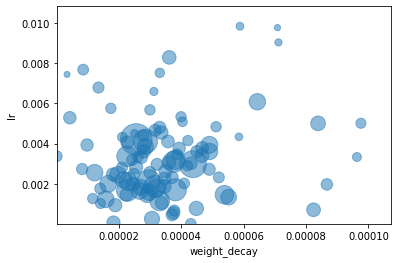

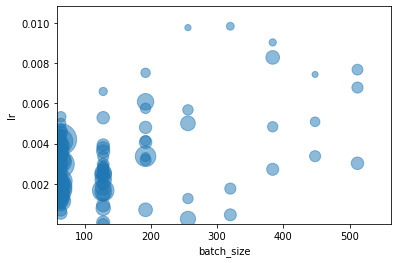

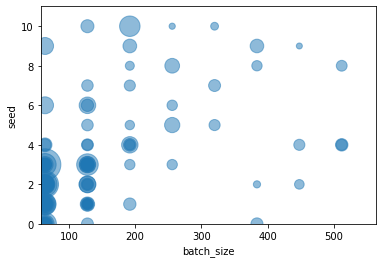

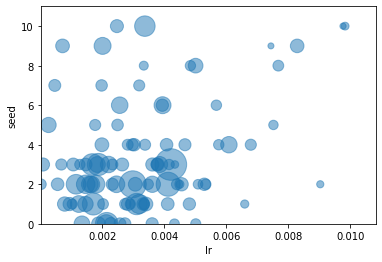

In [2]:
import os
from seminar import show_study

show_study(os.path.join(TRAIN_ROOT, "study.db"))

Что дальше:
* Посмотрите реализацию prepare_config и suggest_config.
* Сделайте параметр "pretrained" модели конфигурируемым и запустите подбор гиперпараметров.
* Попорбуйте сделать параметрические FC и Conv слои, подобрать параметры (например, размер свёртки) на CIFAR10,
* Стандартный pruner из Optuna останавливает тренировку экспериментов, если на первых итерациях модель остаёт от медианы. Попробуйте улучшить качество, подобрав pruner и параметры.